In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
import tensorflow as tf
from keras import backend
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, EfficientNetB5

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [4]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [5]:
def add_cnn_layers(base_model, model):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

In [95]:
def train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val):
    train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train, verbose=1)
    val_loss, val_accuracy = model.evaluate(x_val_normalized, y_val, verbose=1)
    
    #Accuracy
    print("Training Accuracy:",train_accuracy*100,"%","")
    print("Validation Accuracy:",val_accuracy*100,"%","")

    #Loss
    print("\nTraining Loss:",train_loss)
    print("Validation Loss:",val_loss)


In [106]:
def test_accuracy(model, x_test_normalized, y_test):
    test_loss, test_accuracy = model.evaluate(x_test_normalized, y_test, verbose=1)

    print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss)

In [8]:
def plot_model_history(model_history, name):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    #Summarize history for accuracy
    axs[0,0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0,0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0,0].set_title('Model Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    axs[0,1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[0,1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[0,1].set_title('Model Loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[0,1].legend(['train', 'validation'], loc='best')
    
    #Summarize history for RMSE
    axs[1,0].plot(range(1,len(model_history.history['rmse'])+1),model_history.history['rmse'])
    axs[1,0].plot(range(1,len(model_history.history['val_rmse'])+1),model_history.history['val_rmse'])
    axs[1,0].set_title('Model RMSE')
    axs[1,0].set_ylabel('RMSE')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_xticks(np.arange(1,len(model_history.history['rmse'])+1),len(model_history.history['rmse'])/10)
    axs[1,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for MSE
    axs[1,1].plot(range(1,len(model_history.history['mse'])+1),model_history.history['mse'])
    axs[1,1].plot(range(1,len(model_history.history['val_mse'])+1),model_history.history['val_mse'])
    axs[1,1].set_title('Model MSE')
    axs[1,1].set_ylabel('MSE')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_xticks(np.arange(1,len(model_history.history['mse'])+1),len(model_history.history['mse'])/10)
    axs[1,1].legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('../Photos/' + name + '_model_history.png', dpi=300)

In [9]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predict the values from the testing set
    y_predict = model.predict(x_test_normalized)

    #Convert prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis = 1) 

    #Convert testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis = 1) 
    
    return y_predict_classes, y_true_classes

In [10]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [11]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('../Photos/' + name + '_confusion_matrix.png', dpi=300)

In [12]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    #Generate report
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

In [13]:
def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):

    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        
    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Calculation confusion matrix prediction error
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1))* 100

    #Bar plot
    plt.bar(np.arange(7), cm_prediction_error)

    #Plot title and labels
    plt.title(name)
    plt.xlabel('True Labels')
    plt.ylabel('Classified Labels %')
    
    #Save figure
    fig = plt
    fig.savefig('../Photos/' + name + '_label_classification_accuracy.png', dpi=300)

In [14]:
base_skin_dir = os.path.join('..', 'data')

In [15]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [16]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [17]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

In [18]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #Image Local Path
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes #Unique code for each 'dx'

In [1]:
skin_df.value_counts()

NameError: name 'skin_df' is not defined

In [20]:
skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [21]:
skin_df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [22]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [23]:
skin_df = skin_df.drop_duplicates(subset='lesion_id')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,../data/HAM10000_images_part_1/ISIC_0025837.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
9994,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face,../data/HAM10000_images_part_2/ISIC_0030877.jpg,Actinic keratoses,0
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,../data/HAM10000_images_part_2/ISIC_0031922.jpg,Actinic keratoses,0
10004,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face,../data/HAM10000_images_part_2/ISIC_0029309.jpg,Actinic keratoses,0
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,../data/HAM10000_images_part_2/ISIC_0033705.jpg,Actinic keratoses,0


In [24]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [25]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [26]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='cell_type'>

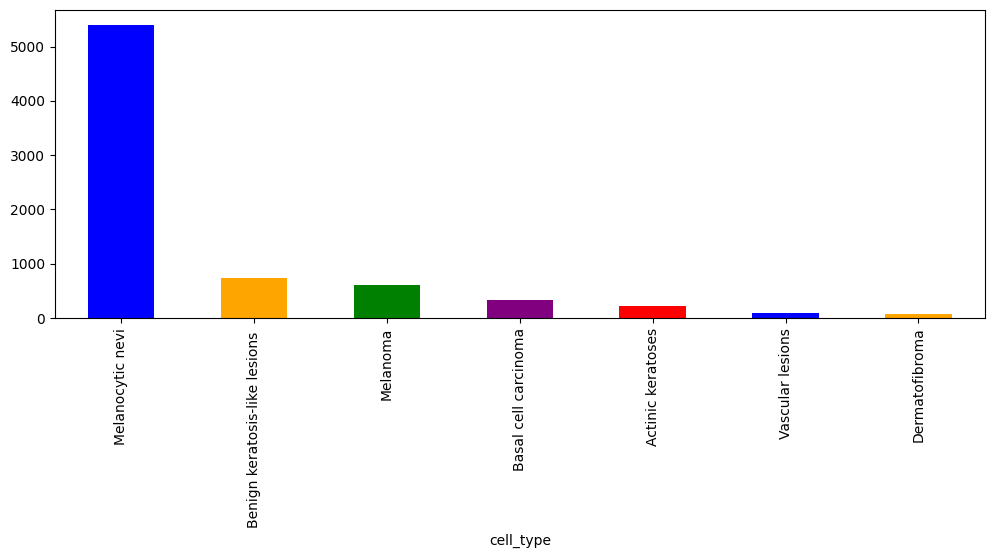

In [27]:
plt.figure(figsize=(12, 4))
skin_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red"])

In [28]:
skin_df['cell_type'].value_counts()
skin_df['dx'].value_counts()

cell_type
Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Vascular lesions                    98
Dermatofibroma                      73
Name: count, dtype: int64

dx
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: count, dtype: int64

Delete Data Imbalanced

In [218]:
skin_df.loc[skin_df.cell_type.isin(["Dermatofibroma", "Vascular lesions"])].index

Index([], dtype='int64')

In [219]:
skin_df.drop(skin_df.loc[skin_df.cell_type.isin(["Dermatofibroma", "Vascular lesions"])].index, inplace=True)

In [220]:
skin_df.cell_type.value_counts()

cell_type
Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Name: count, dtype: int64

In [221]:
cell_type_list = skin_df.cell_type.unique()

In [222]:
cell_type_list

array(['Benign keratosis-like lesions ', 'Melanocytic nevi', 'Melanoma',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [223]:
sample_cell_type = list(filter(lambda x : x != 'Actinic keratoses', cell_type_list))

In [224]:
sample_cell_type

['Benign keratosis-like lesions ',
 'Melanocytic nevi',
 'Melanoma',
 'Basal cell carcinoma']

In [225]:
df_new = skin_df.loc[skin_df.cell_type.isin(["Actinic keratoses"])]

In [226]:
df_new.shape[0]

228

In [227]:
sampled_cell = []
for cell in sample_cell_type : 
    getted_sample = skin_df.loc[skin_df.cell_type.isin([cell])].sample(n=df_new.shape[0], axis=0, random_state=1)
    sampled_cell.append(getted_sample)

In [171]:
sampled_cell

[        lesion_id      image_id   dx    dx_type   age     sex  \
 402   HAM_0001896  ISIC_0030203  bkl      histo  50.0    male   
 1044  HAM_0000643  ISIC_0029731  bkl  consensus  75.0    male   
 298   HAM_0002827  ISIC_0025777  bkl      histo  80.0    male   
 556   HAM_0000979  ISIC_0028043  bkl      histo  70.0    male   
 809   HAM_0005896  ISIC_0027735  bkl   confocal  50.0  female   
 ...           ...           ...  ...        ...   ...     ...   
 491   HAM_0001539  ISIC_0026444  bkl      histo  70.0    male   
 492   HAM_0001605  ISIC_0024422  bkl      histo  75.0    male   
 591   HAM_0003508  ISIC_0030319  bkl      histo  85.0  female   
 1007  HAM_0001997  ISIC_0029251  bkl  consensus  70.0  female   
 983   HAM_0000090  ISIC_0032330  bkl  consensus  65.0  female   
 
          localization                                             path  \
 402              back  ../data/HAM10000_images_part_2/ISIC_0030203.jpg   
 1044             face  ../data/HAM10000_images_part_2/I

In [228]:
df_new = pd.concat(sampled_cell + [df_new])

In [196]:
df_new.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
402,HAM_0001896,ISIC_0030203,bkl,histo,50.0,male,back,../data/HAM10000_images_part_2/ISIC_0030203.jpg,Benign keratosis-like lesions,2,"[[[195, 167, 170], [196, 167, 169], [196, 167,..."
1044,HAM_0000643,ISIC_0029731,bkl,consensus,75.0,male,face,../data/HAM10000_images_part_2/ISIC_0029731.jpg,Benign keratosis-like lesions,2,"[[[189, 92, 94], [191, 93, 93], [191, 91, 92],..."
298,HAM_0002827,ISIC_0025777,bkl,histo,80.0,male,lower extremity,../data/HAM10000_images_part_1/ISIC_0025777.jpg,Benign keratosis-like lesions,2,"[[[131, 99, 94], [130, 93, 86], [137, 99, 87],..."
556,HAM_0000979,ISIC_0028043,bkl,histo,70.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0028043.jpg,Benign keratosis-like lesions,2,"[[[115, 85, 94], [121, 90, 100], [124, 93, 105..."
809,HAM_0005896,ISIC_0027735,bkl,confocal,50.0,female,face,../data/HAM10000_images_part_1/ISIC_0027735.jpg,Benign keratosis-like lesions,2,"[[[170, 133, 158], [168, 130, 158], [167, 128,..."


In [229]:
df_new.cell_type.value_counts()

cell_type
Benign keratosis-like lesions     228
Melanocytic nevi                  228
Melanoma                          228
Basal cell carcinoma              228
Actinic keratoses                 228
Name: count, dtype: int64

In [230]:
df_new.reset_index(inplace=True)

In [199]:
df_new.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,402,HAM_0001896,ISIC_0030203,bkl,histo,50.0,male,back,../data/HAM10000_images_part_2/ISIC_0030203.jpg,Benign keratosis-like lesions,2,"[[[195, 167, 170], [196, 167, 169], [196, 167,..."
1,1044,HAM_0000643,ISIC_0029731,bkl,consensus,75.0,male,face,../data/HAM10000_images_part_2/ISIC_0029731.jpg,Benign keratosis-like lesions,2,"[[[189, 92, 94], [191, 93, 93], [191, 91, 92],..."
2,298,HAM_0002827,ISIC_0025777,bkl,histo,80.0,male,lower extremity,../data/HAM10000_images_part_1/ISIC_0025777.jpg,Benign keratosis-like lesions,2,"[[[131, 99, 94], [130, 93, 86], [137, 99, 87],..."
3,556,HAM_0000979,ISIC_0028043,bkl,histo,70.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0028043.jpg,Benign keratosis-like lesions,2,"[[[115, 85, 94], [121, 90, 100], [124, 93, 105..."
4,809,HAM_0005896,ISIC_0027735,bkl,confocal,50.0,female,face,../data/HAM10000_images_part_1/ISIC_0027735.jpg,Benign keratosis-like lesions,2,"[[[170, 133, 158], [168, 130, 158], [167, 128,..."


In [231]:
df_new.drop(["index", "dx"], inplace=True, axis=1)

In [232]:
df_new.head()

,lesion_id,image_id,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0001896,ISIC_0030203,histo,50.0,male,back,../data/HAM10000_images_part_2/ISIC_0030203.jpg,Benign keratosis-like lesions,2,"[[[195, 167, 170], [196, 167, 169], [196, 167,..."
1,HAM_0000643,ISIC_0029731,consensus,75.0,male,face,../data/HAM10000_images_part_2/ISIC_0029731.jpg,Benign keratosis-like lesions,2,"[[[189, 92, 94], [191, 93, 93], [191, 91, 92],..."
2,HAM_0002827,ISIC_0025777,histo,80.0,male,lower extremity,../data/HAM10000_images_part_1/ISIC_0025777.jpg,Benign keratosis-like lesions,2,"[[[131, 99, 94], [130, 93, 86], [137, 99, 87],..."
3,HAM_0000979,ISIC_0028043,histo,70.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0028043.jpg,Benign keratosis-like lesions,2,"[[[115, 85, 94], [121, 90, 100], [124, 93, 105..."
4,HAM_0005896,ISIC_0027735,confocal,50.0,female,face,../data/HAM10000_images_part_1/ISIC_0027735.jpg,Benign keratosis-like lesions,2,"[[[170, 133, 158], [168, 130, 158], [167, 128,..."


In [233]:
df_new.columns

Index(['lesion_id', 'image_id', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [234]:
df_new.to_csv("../data/balanced_data.csv", index=False)

In [235]:
balanced_df = pd.read_csv("../data/balanced_data.csv")

In [236]:
balanced_df.head()

,lesion_id,image_id,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0001896,ISIC_0030203,histo,50.0,male,back,../data/HAM10000_images_part_2/ISIC_0030203.jpg,Benign keratosis-like lesions,2,[[[195 167 170]\n [196 167 169]\n [196 167 1...
1,HAM_0000643,ISIC_0029731,consensus,75.0,male,face,../data/HAM10000_images_part_2/ISIC_0029731.jpg,Benign keratosis-like lesions,2,[[[189 92 94]\n [191 93 93]\n [191 91 ...
2,HAM_0002827,ISIC_0025777,histo,80.0,male,lower extremity,../data/HAM10000_images_part_1/ISIC_0025777.jpg,Benign keratosis-like lesions,2,[[[131 99 94]\n [130 93 86]\n [137 99 ...
3,HAM_0000979,ISIC_0028043,histo,70.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0028043.jpg,Benign keratosis-like lesions,2,[[[115 85 94]\n [121 90 100]\n [124 93 1...
4,HAM_0005896,ISIC_0027735,confocal,50.0,female,face,../data/HAM10000_images_part_1/ISIC_0027735.jpg,Benign keratosis-like lesions,2,[[[170 133 158]\n [168 130 158]\n [167 128 1...


<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='cell_type'>

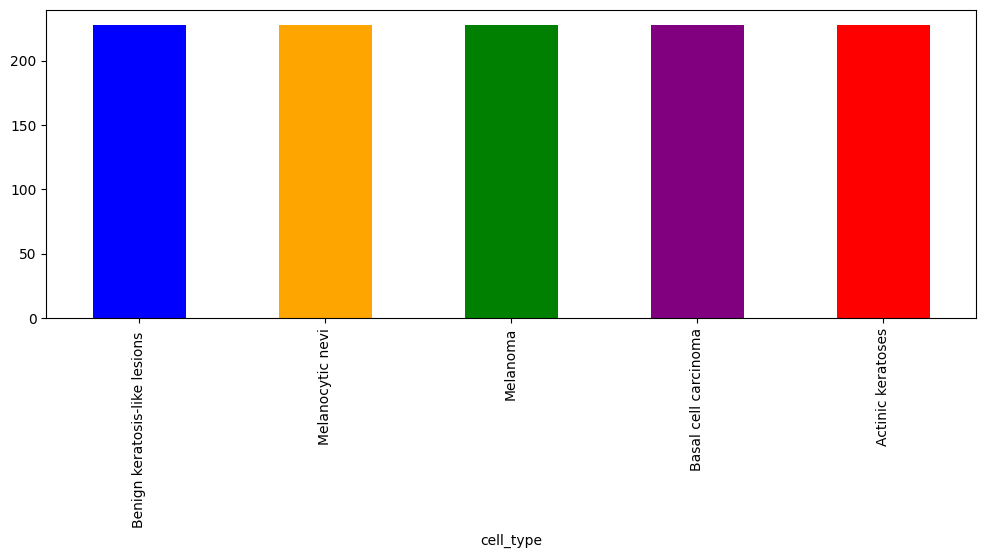

In [237]:
plt.figure(figsize=(12, 4))
balanced_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red"])

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='localization'>

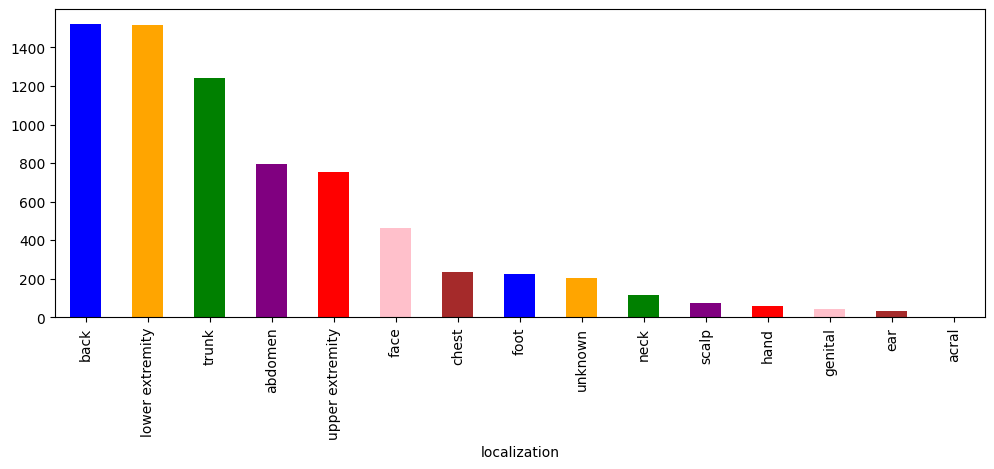

In [239]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red", "pink", "brown"])

<Axes: >

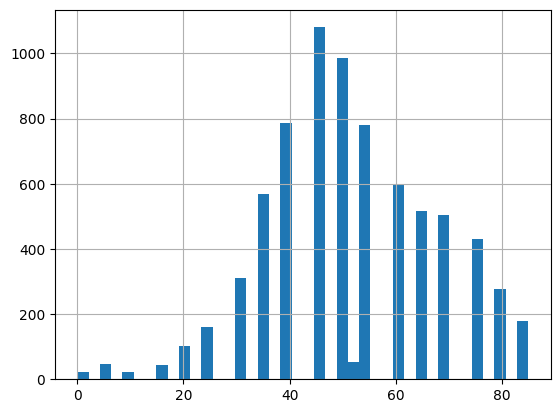

In [31]:
skin_df['age'].hist(bins=40)

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='sex'>

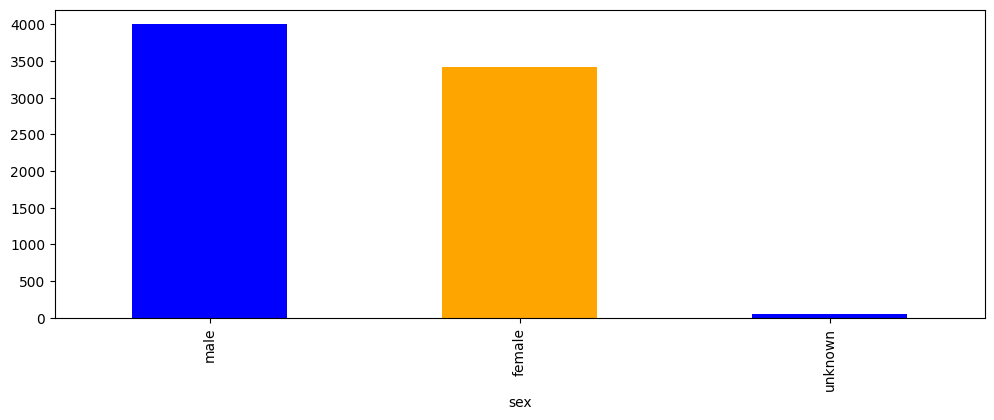

In [32]:
plt.figure(figsize=(12, 4))
skin_df['sex'].value_counts().plot(kind='bar', color=["blue", "orange"])

In [33]:
im = Image.open(skin_df["path"][0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [241]:
# Create a TensorFlow Dataset from the DataFrame.
dataset = tf.data.Dataset.from_tensor_slices((balanced_df["path"], balanced_df["cell_type"]))

In [243]:
for i in dataset:
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/HAM10000_images_part_2/ISIC_0030203.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Benign keratosis-like lesions '>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/HAM10000_images_part_2/ISIC_0029731.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Benign keratosis-like lesions '>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/HAM10000_images_part_1/ISIC_0025777.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Benign keratosis-like lesions '>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/HAM10000_images_part_1/ISIC_0028043.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Benign keratosis-like lesions '>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/HAM10000_images_part_1/ISIC_0027735.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Benign keratosis-like lesions '>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../data/HAM10000_images_part_1/ISIC_0028622.jpg'>, <tf.Tensor: shape=(), dtype=string

In [247]:
# Create a TensorFlow dataset.
dataset = tf.data.Dataset.from_tensor_slices((balanced_df['path'], balanced_df['cell_type_idx']))

# Convert the images to Tensors.
def _decode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

dataset = dataset.map(lambda image_path, label: (_decode_image(image_path), label), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Save the dataset.
dataset.save('tfrecords/file.tfrecords')

In [249]:
tfrecord_file = 'tfrecords/file.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_file)

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
import csv
import os
import shutil

# Load the CSV file.
csv_file = '../data/balanced_data.csv'
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in list(reader)[1:]:
        image_path = row[6]
        label = row[8]

        # Create the output directory.
        output_dir = os.path.join('dataset', label)
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)

        # Copy the image to the output directory.
        image_name = os.path.basename(image_path)
        output_path = os.path.join(output_dir, image_name)
        shutil.copyfile(image_path, output_path)

Targeting One-Hot Encoding

We first split the dataset to 80% training data and 20% testing data. We then take the 80% training data and split it into 87.5% training data and 12.5% validation data, to form our 70% Training - 10% Validation - 20% Testing. Note that the split will be applied across each class individually to ensure there is enough samples from each class in each split for accurate modeling, meaning each class will be split 70:10:20 as well. This is done by setting 'stratify' in train_test_split function to our target.

Training: 80% * 87.5% = 70%
Validation: 80% * 12.5% = 10%
Testing: 20%

The hold-out method was prefered over the K-fold method here. K-fold cross-validation is often used for simple models with few parameters, models with simple hyperparameters and that are easy to optimize. Typical examples are linear regression, logistic regression, small neural networks and support vector machines. For a convolutional neural network with many parameters (e.g. more than one million) we just have too many possible changes in the architecture. In addition, lets look at a very important concept in machine learning; variance error vs. biased error. Let us say you have N models that you trained, they all have variance error and zero biased error, in this case using cross validation to select a model is not useful, but averaging the models is useful. If you have N models that all have different biased errors (non zero), then using cross validation is useful to select the best model, but averaging is harmful. Anytime you have models that have different biased errors, use cross validation to determine the best model. Anytime you have models that have variance errors, use averaging to determine the final outcome. CNN has tendency toward overfitting not underfitting. Today we know that the deeper the network the better it is, but overfitting is what scares us. Example: Alex-Hinton paper in 2012 (http://www.cs.toronto.edu/~hinton/absps/imagenet.pdf), the paper where Alex proposed his AlexNet network. You will see that most of the tricks they proposed is to deal with overfitting (variance error) and not biased errors.
80:20 Train Test Split

Features Normalization

In [43]:
# x_train_images = np.asarray(X_train['image'].tolist())
# x_val_images = np.asarray(X_val['image'].tolist())
# x_test_images = np.asarray(X_test['image'].tolist())

In [44]:
# x_train_mean = np.mean(x_train_images)
# x_train_std = np.std(x_train_images)

In [45]:
# x_train_normalized = (x_train_images - x_train_mean)/x_train_std
# x_val_normalized = (x_val_images - x_train_mean)/x_train_std
# x_test_normalized = (x_test_images - x_train_mean)/x_train_std

In [46]:
# input_shape = (int(width), int(height), 3)
# x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
# x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
# x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))

In [335]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last', 
                                    validation_split=0.0, 
                                    interpolation_order=1, 
                                    dtype='float32')

In [336]:
# augmented_data.fit(x_train_normalized)

In [49]:
#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 112, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 112, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 56, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 56, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 56, 64)        36928     
                                                        

In [50]:
import tensorflow.keras.optimizers as tko
optimizer = tko.Adam(lr=0.001)

In [51]:
loss = "categorical_crossentropy"

In [52]:
metrics=["accuracy"]

In [53]:
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [54]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001) # Scheduler Learning Rate

In [55]:
skin_df.loc[skin_df['dx'] == 'akiec', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bcc', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bkl', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'df', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'nv', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'mel', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'vasc', ['cell_type', 'cell_type_idx']].head(1)

,cell_type,cell_type_idx
9687,Actinic keratoses,0


,cell_type,cell_type_idx
2462,Basal cell carcinoma,1


,cell_type,cell_type_idx
0,Benign keratosis-like lesions,2


,cell_type,cell_type_idx
1095,Dermatofibroma,3


,cell_type,cell_type_idx
64,Melanocytic nevi,4


,cell_type,cell_type_idx
1211,Melanoma,5


,cell_type,cell_type_idx
2320,Vascular lesions,6


In [56]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # nv # Try to make the model more sensitive to Melanocytic nevi
    5: 1.0, # mel
    6: 1.0, # vasc
}

In [57]:
epochs = 10
batch_size = 8
steps_per_epoch = len(x_train_normalized) / batch_size

Hyper Parameter, inisialisasi yang diset sebelum melakukan training, dan parameter ini yang bisa di intervensi sm manusia, sedangkan parameter itu mesinnya langsung, semisal hp itu epoch, optimizer, loss function, activition function, batch size

In [58]:
time_callback = TimeHistory()
csv_logger = CSVLogger('../logs/original_cnn_training.log', separator=',', append=False)
history = model.fit(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                              epochs = epochs, 
                              verbose = 1,
                              class_weight = class_weights,
                              validation_data = (x_val_normalized, y_val), 
                              steps_per_epoch = steps_per_epoch,
                              callbacks = [reduce_lr, time_callback, csv_logger])

Epoch 1/10
597/597 [==============================] - 87s 145ms/step - loss: 1.2279 - accuracy: 0.7222 - val_loss: 0.9024 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 2/10
597/597 [==============================] - 88s 148ms/step - loss: 1.0771 - accuracy: 0.7232 - val_loss: 1.0679 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 3/10
597/597 [==============================] - 90s 151ms/step - loss: 1.0294 - accuracy: 0.7232 - val_loss: 0.8754 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 4/10
598/597 [==============================] - ETA: 0s - loss: 1.0113 - accuracy: 0.7234
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
597/597 [==============================] - 91s 152ms/step - loss: 1.0113 - accuracy: 0.7234 - val_loss: 0.8185 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 5/10
597/597 [==============================] - 92s 155ms/step - loss: 0.9577 - accuracy: 0.7232 - val_loss: 0.8167 - val_accuracy: 0.7232 - lr: 5.0000e-04
Epoch 6/10
597/597 [=========================

In [59]:
print("\nTotal Time:",sum(time_callback.times),"s\n")


Total Time: 943.3683598041534 s



In [60]:
model.save('../Models/original_cnn_model.h5.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# # serialize model to JSON
# model_json = model.to_json()
# with open('../Models/original_cnn_model.h5.json', "w") as json_file:
#     json_file.write(model_json)
# print("Saved model's architecture to disk")

# # serialize weights to HDF5
# model.save_weights('../Models/original_cnn_model.h5.h5')
# print("Saved model's weights to disk")

In [91]:
model = load_model("../Models/original_cnn_model.h5.h5")
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [63]:
model_log_data = pd.read_csv('../logs/original_cnn_training.log', sep=',', engine='python')

In [64]:
model_name = "BasicCNN"

Inception v3 is the third edition of the widely-used Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. The 48-layered model is the culmination of many ideas developed by multiple researchers over the years.

In [337]:
base_model = InceptionV3(input_shape=(228, 228, 3), include_top=False, weights='imagenet')

In [338]:
base_model.trainable = False

In [339]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax'),
])

In [340]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [341]:
train_data, val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset',
    batch_size=8,
    shuffle=False,
    subset="both",
    image_size=(228, 228),
    validation_split=0.3
)

Found 1140 files belonging to 5 classes.
Using 798 files for training.
Using 342 files for validation.


In [342]:
for image, label in val_data.take(1):
    print(image.shape, label)

(8, 228, 228, 3) tf.Tensor([3 3 3 3 3 3 3 3], shape=(8,), dtype=int32)


In [343]:
checkpoint_path = "checkpoint/model"

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_best_only=True,
)

In [ ]:
model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[callback])

In [70]:
print("\nTotal Time:",sum(inception_time_callback.times),"s\n")


Total Time: 1861.1332876682281 s



In [71]:
inception_model.save('../Models/inception_model_50epochs.h5')
print("Saved entire model file to disk")

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved entire model file to disk


In [72]:
inception_model = load_model('../Models/inception_model_50epochs.h5')
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [73]:
inception_log_data = pd.read_csv('../logs/inception_training.log', sep=',', engine='python')

In [74]:
inception_model_name = "InceptionV3"

In [75]:
base_efnet_model = EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

In [76]:
base_efnet_model.trainable = False

In [77]:
model = Sequential([
    base_efnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [124]:
efnet_model = Sequential()
efnet_model = add_cnn_layers(base_efnet_model, efnet_model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 5, 4, 2048)        28513527  
 )                                                               
                                                                 
 conv2d_101 (Conv2D)         (None, 5, 4, 64)          1179712   
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [126]:
efnet_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [103]:
efnet_time_callback = TimeHistory()
efnet_csv_logger = CSVLogger('../logs/efnet_training.log', separator=',', append=False) 
efnet_history = efnet_model.fit(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                      epochs = epochs, 
                                      verbose = 1,
                                      class_weight = class_weights,
                                      validation_data = (x_val_normalized, y_val), 
                                      steps_per_epoch = steps_per_epoch,
                                      callbacks=[reduce_lr, efnet_time_callback, efnet_csv_logger])


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/homebrew/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/opt/homebrew/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/s1suu/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/50/f9j307152c96gfl9f3nhphqw0000gn/T/ipykernel_61748/1937231180.py", line 3, in <module>
      efnet_history = efnet_model.fit(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[8,6] labels_size=[8,7]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_257077]

In [86]:
print("\nTotal Time:",sum(efnet_time_callback.times),"s\n")


Total Time: 1336.4526481628418 s



In [87]:
efnet_model.save('../Models/efnet_model_50epochs.h5')
print("Saved entire model file to disk")

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved entire model file to disk


In [88]:
efnet_model = load_model('../Models/efnet_model_50epochs.h5')
print("Loaded entire model file from disk")

Loaded entire model file from disk


In [89]:
efnet_model_name = "EfficientNetB5"

Transfer learning-> inc top karna membuang head dari vgg16 train modelsnya, karena kita akan melakukan tf learning, so head akan diganti menjadi classifier yang menyesuaikan dataset yang ada. 

Calculate Training and Validation Sets Accuracy + Loss + Errors
This Section Contains Training and Validation Data

Basic CNN

In [104]:
train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 4s 116ms/step - loss: 0.8339 - accuracy: 0.7232
Training Accuracy: 72.34309911727905 % 
Validation Accuracy: 72.32441306114197 % 

Training Loss: 0.7861164808273315
Validation Loss: 0.8339399695396423


InceptionV3x

In [97]:
train_val_accuracy(inception_model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 8s 197ms/step - loss: 0.9671 - accuracy: 0.7232
Training Accuracy: 72.34309911727905 % 
Validation Accuracy: 72.32441306114197 % 

Training Loss: 0.9559938907623291
Validation Loss: 0.9671003222465515


EfficientNetB5

In [98]:
train_val_accuracy(efnet_model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 21s 546ms/step - loss: 1.0197 - accuracy: 0.7232
Training Accuracy: 72.34309911727905 % 
Validation Accuracy: 72.32441306114197 % 

Training Loss: 1.0188676118850708
Validation Loss: 1.0197207927703857


Calculate Testing Set Accuracy + Loss + Errors

In [107]:
test_accuracy(model, x_test_normalized, y_test) # CNN Basic

47/47 [==============================] - 7s 139ms/step - loss: 0.8617 - accuracy: 0.7229

Test Set Accuracy:  72.28915691375732 % 
Test Set Loss: 0.8617315292358398


In [108]:
test_accuracy(inception_model, x_test_normalized, y_test) # Inception

47/47 [==============================] - 9s 182ms/step - loss: 0.9783 - accuracy: 0.7229

Test Set Accuracy:  72.28915691375732 % 
Test Set Loss: 0.9783381819725037


In [123]:
# test_accuracy(efnet_model, x_test_normalized, y_test) # EfficientNetB5
model.evaluate(efnet_model)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

Pertama, semua akurasi pengujian sebanding dengan akurasi validasi, lebih lanjut meneguhkan fakta bahwa semua model tidak cocok atau terlalu cocok. VGG16 memuncaki akurasi set tes, diikuti oleh ResNet 152V2, kemudian oleh Basic CNN, dan terakhir, oleh Inception V3.

Testing Set Confusion Matrix for True vs Predicted Labels

Setting the confusion matrix plot labels (used across all models)

In [111]:
#Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

47/47 [==============================] - 6s 115ms/step


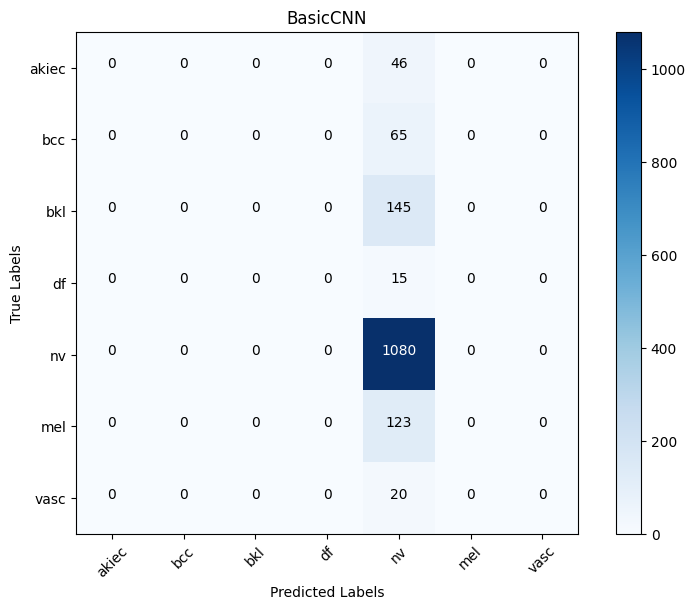

In [112]:
create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, model_name) # CNN Basic

47/47 [==============================] - 9s 174ms/step


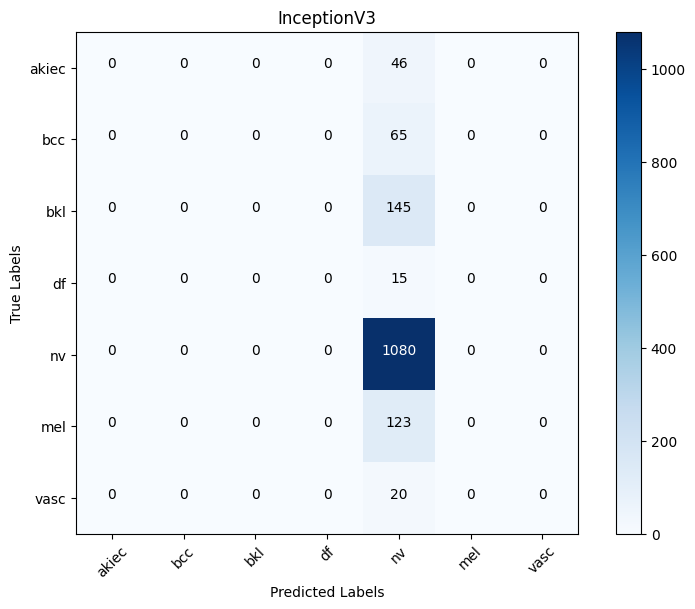

In [113]:
create_confusion_matrix(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name) # Inception V3

47/47 [==============================] - 29s 577ms/step


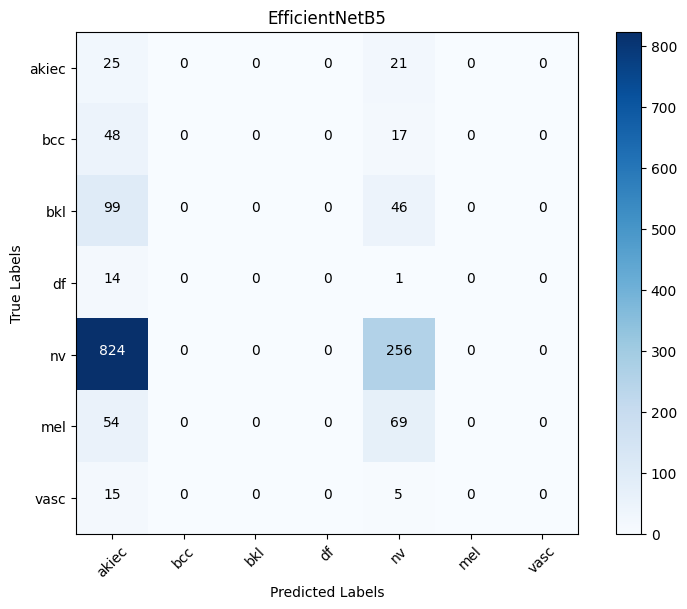

In [114]:
create_confusion_matrix(efnet_model, x_test_normalized, y_test, cm_plot_labels, efnet_model_name) # ResNet152 V2

efficient miss class

Generate a Confusion Matrix Classification Report

In [115]:
gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels) # Basic CNN

47/47 [==============================] - 6s 117ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        46
         bcc       0.00      0.00      0.00        65
         bkl       0.00      0.00      0.00       145
          df       0.00      0.00      0.00        15
          nv       0.72      1.00      0.84      1080
         mel       0.00      0.00      0.00       123
        vasc       0.00      0.00      0.00        20

    accuracy                           0.72      1494
   macro avg       0.10      0.14      0.12      1494
weighted avg       0.52      0.72      0.61      1494



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
gen_classification_report(inception_model, x_test_normalized, y_test, cm_plot_labels) # Inception V3

47/47 [==============================] - 9s 197ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        46
         bcc       0.00      0.00      0.00        65
         bkl       0.00      0.00      0.00       145
          df       0.00      0.00      0.00        15
          nv       0.72      1.00      0.84      1080
         mel       0.00      0.00      0.00       123
        vasc       0.00      0.00      0.00        20

    accuracy                           0.72      1494
   macro avg       0.10      0.14      0.12      1494
weighted avg       0.52      0.72      0.61      1494



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
gen_classification_report(efnet_model, x_test_normalized, y_test, cm_plot_labels) # ResNest152V2

47/47 [==============================] - 27s 562ms/step
              precision    recall  f1-score   support

       akiec       0.02      0.54      0.04        46
         bcc       0.00      0.00      0.00        65
         bkl       0.00      0.00      0.00       145
          df       0.00      0.00      0.00        15
          nv       0.62      0.24      0.34      1080
         mel       0.00      0.00      0.00       123
        vasc       0.00      0.00      0.00        20

    accuracy                           0.19      1494
   macro avg       0.09      0.11      0.06      1494
weighted avg       0.45      0.19      0.25      1494



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 [==============================] - 6s 126ms/step


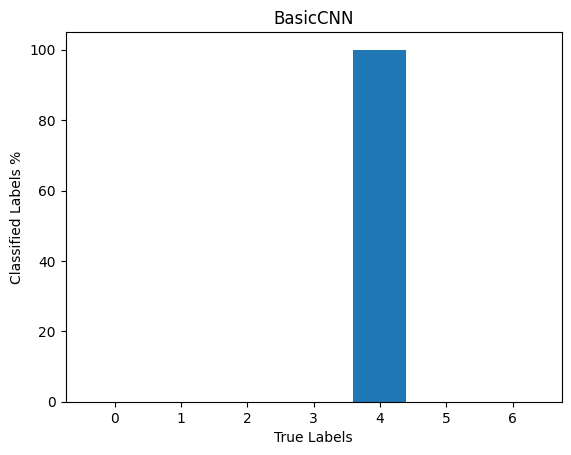

In [118]:
plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, model_name) # CNN Basic

47/47 [==============================] - 10s 202ms/step


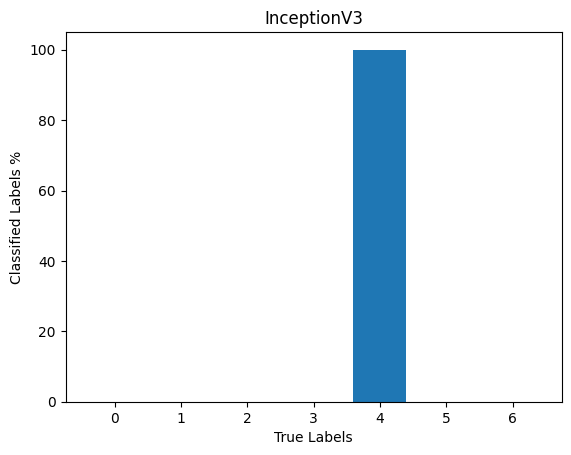

In [119]:
plot_label_classification_acc(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name) # Inception V3

47/47 [==============================] - 24s 511ms/step


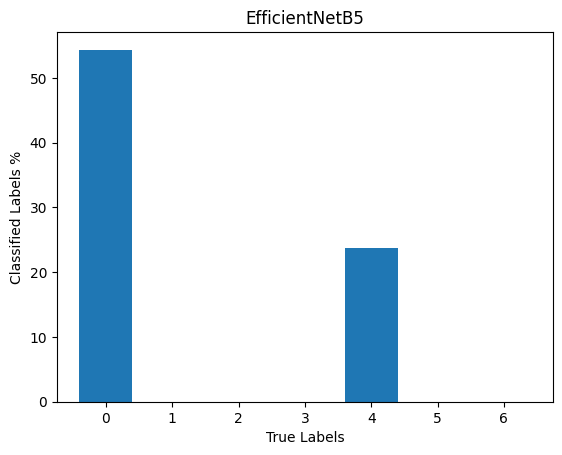

In [120]:
plot_label_classification_acc(efnet_model, x_test_normalized, y_test, cm_plot_labels, efnet_model_name) # EfficientNet